# **Passenger prediction with XGBRegressor** 
~ H. L. Burger 

In [50]:
pip install "optuna"

     |████████████████████████████████| 365 kB 24.0 MB/s            
     |████████████████████████████████| 210 kB 52.7 MB/s            
     |████████████████████████████████| 78 kB 13.6 MB/s            
You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [68]:
#Imports necessary packages
import numpy as np 
import pandas as pd

import scipy.stats as ss                                                              #}
import statsmodels.api as sma                                                         #}Statistical tests
import statsmodels.tsa.api as smt                                                     #}
import optuna

import matplotlib.pyplot as plt                                                       #}Visualisations
import seaborn as sns                                                                 #}

import datetime                                                                       #Datetime transformations

from workalendar.europe import NetherlandsWithSchoolHolidays as NL                    #Additional holiday data

from xgboost import XGBRegressor                                                      #}Statistical models
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error        #}

import warnings
warnings.filterwarnings('ignore')

In [69]:
# get datetime dates and redefine a new dataframe with variable of interest.
ts = pd.to_datetime(df['Geplande datum/tijd'], errors='coerce')
red_df = df[['Pay pax']]
red_df['timestamp'] = ts

red_df = (red_df.set_index('timestamp')
        .resample('D').sum()
        ['2014':'2019']
       )

## Feature engineering 

Performed on the "data" datbase

In [70]:
# Function to find the number of the week in a month
def WeekNumber(date_value):
    week = date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1
    return date_value.isocalendar()[1] if week < 0 else week

In [71]:
# Rename target variable
red_df = red_df.rename(columns={"Pay pax": "Pay_pax"})

red_df['Days_of_year'] = red_df.index.dayofyear                                        #}Various datetime related variables 
red_df['Month'] = red_df.index.month                                                   #}are added to the dataset to 
red_df['Week'] = red_df.index.week                                                     #}indicate importance of time to the 
red_df['Week_Month'] = [WeekNumber(i) for i in red_df.index]                           #}model.
red_df['Day_Number'] = red_df.index.day                                                #}


#Fills empty data with 0
red_df = red_df.fillna(0)

#Holidays variable
calendar = NL(region='south', carnival_instead_of_spring=True)
all_holidays = []
for i in list(red_df.index.year.unique())[2:]:
    for j in calendar.holidays(i):
        all_holidays.append(j[0])

red_df['Holidays'] = [1 if i in all_holidays else 0 for i in red_df.index]

#adds mean value and variance to the model
red_df["RM_10"] = red_df["Pay_pax"].rolling(10).mean()
red_df["SD_30"] = red_df["Pay_pax"].rolling(30).std()

# One data point is negative, transforms to positive
red_df[red_df['Pay_pax'] < 1] = 1

## Visualisations 

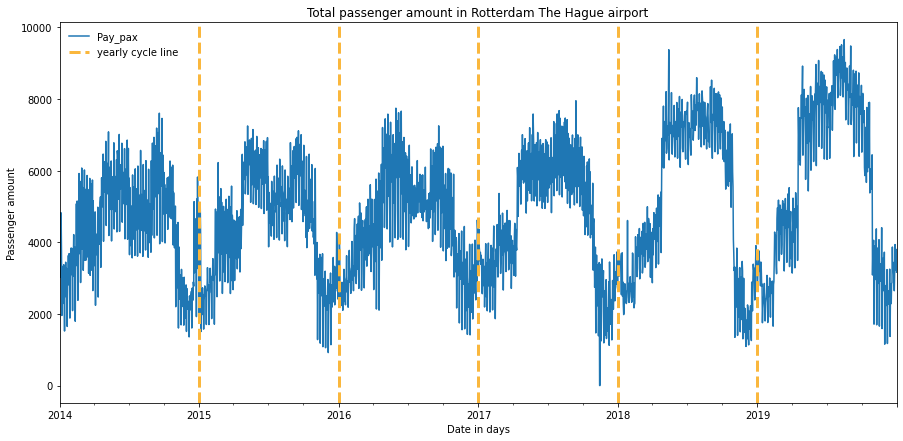

In [19]:
pax_plot = red_df[["Pay_pax"]].plot(figsize = (15,7))
pax_plot = pax_plot.set(title = "Total passenger amount in Rotterdam The Hague airport", 
                                    autoscaley_on = True, xlabel = "Date in days", ylabel = "Passenger amount")
for line in [ "2015-01-01", '2016-01-01', "2017-01-01", "2018-01-01"]:
    plt.axvline(x = line, c = "#fab73d", lw = 3, ls = "--")

plt.axvline(x = "2019-01-01", label ="yearly cycle line", c = "#fab73d", lw = 3, ls = "--")
leg = plt.legend(frameon = False, fontsize = "medium")

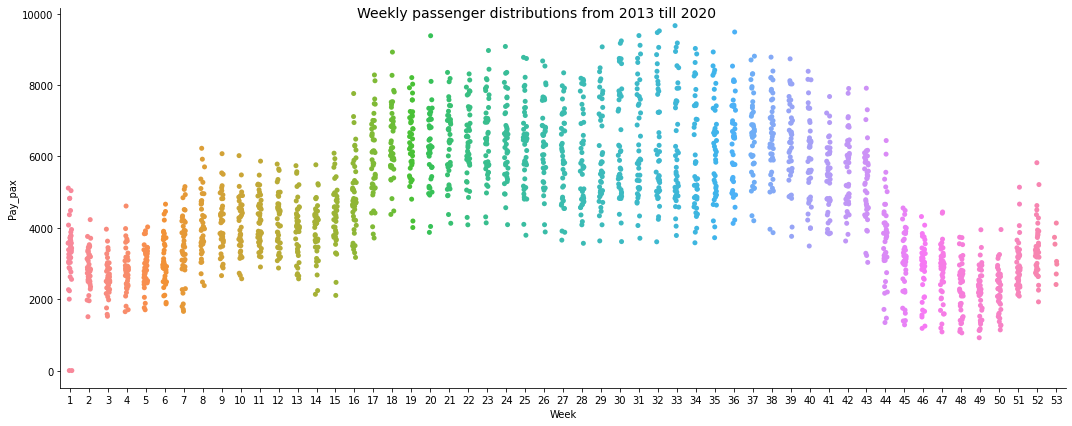

In [45]:
# Visualize possible seasonal effects (weekly)
plot = sns.catplot(data = red_df, x= "Week", y = "Pay_pax", aspect = 2.5, height = 6)
title = plot.fig.suptitle("Weekly passenger distributions from 2013 till 2020", fontsize = 14)

In [72]:
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y,pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout,(0,0),colspan=2)
        
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))
        qq_ax = plt.subplot2grid(layout,(2,0))
        pp_ax = plt.subplot2grid(layout,(2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sma.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        ss.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

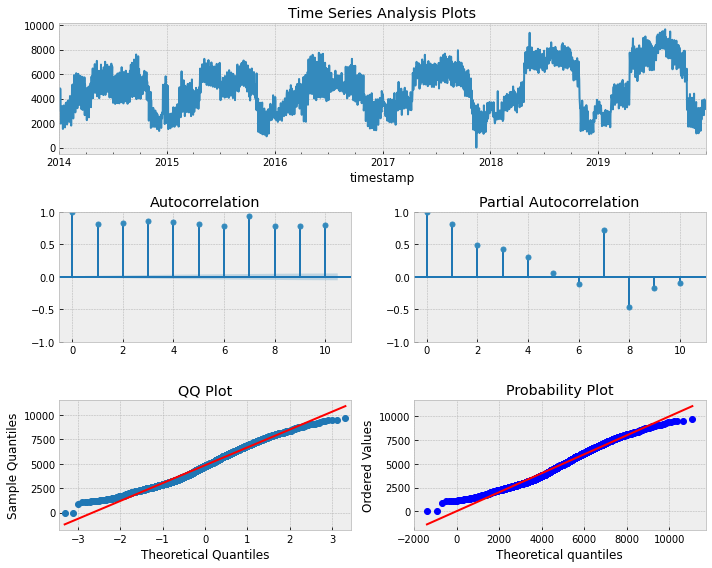

In [73]:
tsplot(red_df['Pay_pax'], lags=10)

## TS analysis Remarks 

The partial autocorrelation shows great importance in 7 day past data, implying a weekly autocorrelation. Therefore, past data (if available) should be added to the model on weekly cycles. (7, 14, 21,28)

In [74]:
red_df["Pay_pax_S30"] = red_df["Pay_pax"].shift(30)

## XGBRegressor
#### Forecasting using a CART model

In [64]:
red_df.columns

Index(['Pay_pax', 'Days_of_year', 'Month', 'Week', 'Week_Month', 'Day_Number',
       'Day_Name', 'Holidays', 'RM_10', 'SD_30'],
      dtype='object')

In [95]:
#Trial function to indicate effectiveness of each parameter (with Root Mean Squared Error)
def trial(trial):
    lr = trial.suggest_float("lr", 1e-2, 1 )
    max_depth = trial.suggest_int("max_depth", 1, 30)
    n_estimators = trial.suggest_int("n_estimators", 1, 50)

    y_to_train = red_df["2016":"2018"]
    y_to_val = red_df[" 2019":]

    X_train_L = y_to_train.drop(columns = ["Pay_pax"])
    y_train_L = y_to_train.Pay_pax.values
    X_val_L = y_to_val.drop(columns = ["Pay_pax"])
    y_val_L = y_to_val.Pay_pax.values
    
    model = XGBRegressor(learning_rate = lr, max_depth = max_depth, n_estimators = n_estimators)
    model.fit(X_train_L, y_train_L)
    pred = model.predict(X_val_L)

    rmse = np.sqrt(mean_squared_error(y_val_L, pred))
    return rmse

#Run the trial 100 times with the objective of minimization
study = optuna.create_study(direction = "minimize")
study.optimize(trial, n_trials = 100, show_progress_bar=True)

[I 2023-01-22 22:56:23,134] Trial 0 finished with value: 784.7539993070911 and parameters: {'lr': 0.8093556757776815, 'max_depth': 4, 'n_estimators': 50}. Best is trial 0 with value: 784.7539993070911.
[I 2023-01-22 22:56:23,249] Trial 1 finished with value: 812.826382891338 and parameters: {'lr': 0.942653216048811, 'max_depth': 3, 'n_estimators': 31}. Best is trial 0 with value: 784.7539993070911.
[I 2023-01-22 22:56:23,527] Trial 2 finished with value: 809.0072705667906 and parameters: {'lr': 0.8076136633945589, 'max_depth': 14, 'n_estimators': 35}. Best is trial 0 with value: 784.7539993070911.
[I 2023-01-22 22:56:23,770] Trial 3 finished with value: 779.430303708194 and parameters: {'lr': 0.15463722186300705, 'max_depth': 14, 'n_estimators': 36}. Best is trial 3 with value: 779.430303708194.
[I 2023-01-22 22:56:23,818] Trial 4 finished with value: 1767.9290557642391 and parameters: {'lr': 0.1990030190009242, 'max_depth': 4, 'n_estimators': 7}. Best is trial 3 with value: 779.430303

[I 2023-01-22 22:56:21,867] A new study created in memory with name: no-name-31397ec5-5753-4c90-98af-7f69353e123f


In [79]:
optuna.visualization.plot_slice(study)

## Slice Plot Remarks
The slice plot shows each trained parameter of an XGBRegressor to indicate a rough optimum area (best value). As seen in the slice plot, lr and max_depth decrease in objective value at low parameter value and remain stable when increasing in objective value. The same can be said for n_estimators, which shows an exponential decay in objective value in the beginning, stabilizing after 20 estimators. 

Crowded indications are established as optimum area, resulting in the following values:

lr = 0.75,
max_depth = 5,
n_estimators = 30

In [115]:
#The following function provides the predicted values, RMSE and MAPE with a certain prediction range
def get_comb_xgb(shift_list, date_range):
    xgb_data = red_df
    pred_list = []
    actual_list = []
    for shift in shift_list:
        xgb_data["Pay_pax_shift_" + str(shift)] = red_df["Pay_pax"].shift(shift)

        xgb_X_to_train = xgb_data.loc[date_range[0] : date_range[1]].drop(columns = "Pay_pax")
        xgb_X_to_val = xgb_data.loc[date_range[1] : date_range[2]].drop(columns = "Pay_pax")
        xgb_y_to_train = xgb_data.loc[date_range[0] : date_range[1]][["Pay_pax"]]
        xgb_actual = xgb_data.loc[date_range[1] : date_range[2]][["Pay_pax"]][int(shift - (max(shift_list)/len(shift_list))):shift].values.reshape(1,int(max(shift_list)/len(shift_list)))[0]

        model_xgb = XGBRegressor(learning_rate = 0.75, max_depth = 5, n_estimators = 30)
        model_xgb.fit(xgb_X_to_train, xgb_y_to_train)
        pred = model_xgb.predict(xgb_X_to_val)[int(shift - (max(shift_list)/len(shift_list))):shift]
        pred_list.extend(pred)
        actual_list.extend(xgb_actual)
        
        xgb_X_to_train.drop(["Pay_pax_shift_" + str(shift)], axis = 1)
        xgb_X_to_val.drop(["Pay_pax_shift_" + str(shift)], axis = 1)

    
    rmse = np.sqrt(mean_squared_error(actual_list, pred_list))
    
    return pred_list, rmse
    
    
        
            


In [116]:
def Cross_Val(training_period, forecast_period, shift_list, options='RW', fig_display=True):
    '''
    
    Function to perform timeseries forecasting validation:
    INPUT: Training_period = int - length of the training sample
    INPUT: Forecasting_period = int - amount of days to predict
    INPUT: options = str - takes either RW (Rolling Windows) or EX (Expending window)
    OUTPUT: all_mse = list - all RMSE values
    OUTPUT: all_predic = list - all out of samples predictions
    
    '''
    all_mse = []
    all_predic = []
    start_training_date = red_df['Pay_pax'].index[0]
    end_training_date = red_df['Pay_pax'].index[training_period]
    nb_iter = len(red_df['Pay_pax'][end_training_date:])//int(max(shift_list)/len(shift_list)) #numbers of periods to predict
    
    # first iteration
    date_range = [start_training_date, end_training_date, (end_training_date + datetime.timedelta(days=forecast_period))]
    combined_pred, rmse = get_comb_xgb(shift_list, date_range)
    
    
    all_mse.append(rmse)
    all_predic.append(combined_pred)

    
    if options=='RW':
        for i in range(1, nb_iter - int(len(shift_list)) + 1):
            print('iteration #'+str(i))
            start_training_date += datetime.timedelta(days=int(max(shift_list)/len(shift_list)))
            end_training_date += datetime.timedelta(days=int(max(shift_list)/len(shift_list)))
            date_range = [start_training_date, end_training_date, (end_training_date + datetime.timedelta(days=forecast_period)) ]
            combined_pred, rmse = get_comb_xgb(shift_list, date_range)
            
            
            all_mse.append(rmse)
            all_predic.append(combined_pred)
            
    elif options == 'EX':
        for i in range(1, nb_iter - int(len(shift_list)) + 1):
            print('iteration #'+str(i))
            end_training_date += datetime.timedelta(days=int(max(shift_list)/len(shift_list)))
            date_range = [start_training_date, end_training_date, (end_training_date + datetime.timedelta(days=forecast_period)) ]
            combined_pred, rmse = get_comb_xgb(shift_list, date_range)
            
            
            all_mse.append(rmse)
            all_predic.append(combined_pred)
        
    else: 
        print('Options type not recognized: Please choose either RW or EX')
        return None
             
    return all_mse, all_predic

In [88]:
?XGBRegressor

Init signature:
XGBRegressor(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.


Parameters
----------

    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    objective : typing.Union[str, typing.Callable[[numpy.ndarray, numpy.ndarray], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: Optional[str]
        

In [117]:
#all_mse1, all_predic1 = Cross_Val(training_period=400, forecast_period=28, shift_list = [7,14,21,28], options='RW', fig_display=False)
#all_mse2, all_predic2 = Cross_Val(training_period=400, forecast_period=28, shift_list = [7,14,21,28], options='EX', fig_display=False)
#all_mse3, all_predic3 = Cross_Val(training_period=400, forecast_period=28, shift_list = [28], options='RW', fig_display=False)
all_mse4, all_predic4 = Cross_Val(training_period=400, forecast_period=28, shift_list = [28], options='EX')

iteration #1
iteration #2
iteration #3
iteration #4
iteration #5
iteration #6
iteration #7
iteration #8
iteration #9
iteration #10
iteration #11
iteration #12
iteration #13
iteration #14
iteration #15
iteration #16
iteration #17
iteration #18
iteration #19
iteration #20
iteration #21
iteration #22
iteration #23
iteration #24
iteration #25
iteration #26
iteration #27
iteration #28
iteration #29
iteration #30
iteration #31
iteration #32
iteration #33
iteration #34
iteration #35
iteration #36
iteration #37
iteration #38
iteration #39
iteration #40
iteration #41
iteration #42
iteration #43
iteration #44
iteration #45
iteration #46
iteration #47
iteration #48
iteration #49
iteration #50
iteration #51
iteration #52
iteration #53
iteration #54
iteration #55
iteration #56
iteration #57
iteration #58
iteration #59
iteration #60
iteration #61
iteration #62


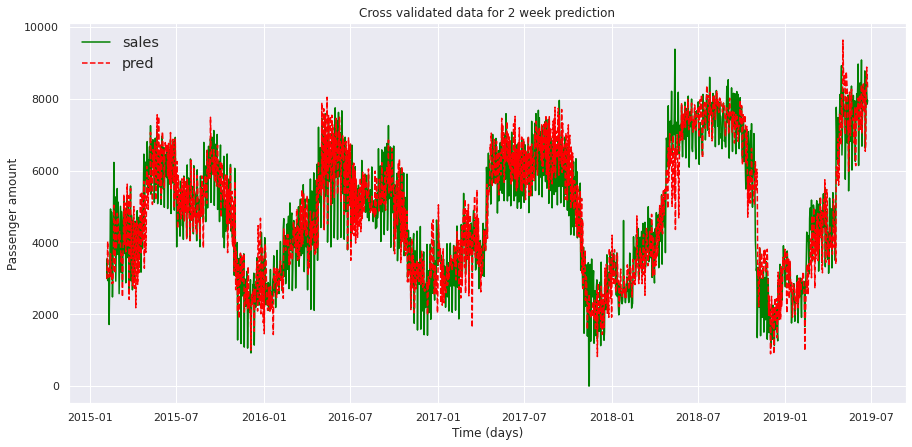

In [118]:
sns.set_style("dark")
sns.set_context("paper")
sns.set(rc={'figure.figsize':(15,7)})

xg_plot = sns.lineplot(y = red_df.Pay_pax[400:2000], x = red_df.index[400:2000], color = "green")
xg_plot = sns.lineplot(y = [i for sub in all_predic4 for i in sub][:1600], x = red_df.index[400:2000], color = "red")
xg_plot.lines[1].set_linestyle("--")
xg_plot.set(title = "Cross validated data for 2 week prediction", xlabel = "Time (days)", ylabel = "Passenger amount")
#sns.lineplot(y = abs(y_valid["sales"] - y_valid["pred"]), x = y_valid.index )
leg = plt.legend(labels = ['sales', 'pred'], fontsize= "large", frameon = False)

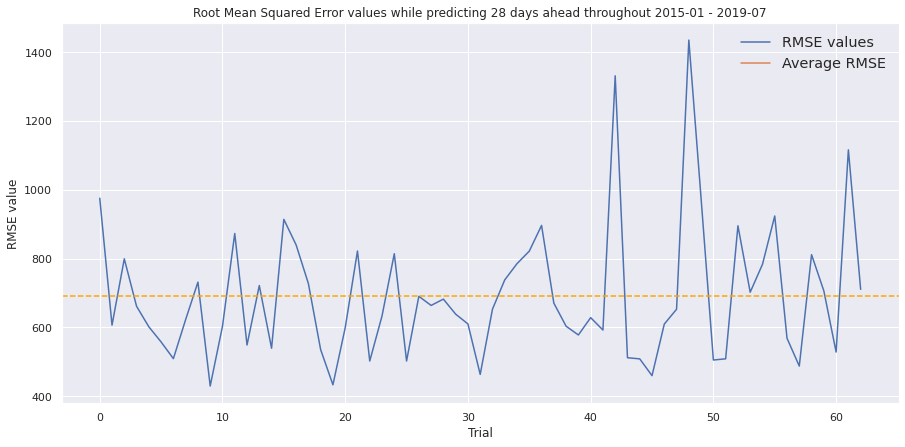

In [119]:
plt.plot(all_mse4)

rmse_plot = sns.lineplot(all_mse4)
mean_line = rmse_plot.axhline(np.mean(all_mse4), color = "orange")
rmse_plot.set(title = "Root Mean Squared Error values while predicting 28 days ahead throughout 2015-01 - 2019-07",
              xlabel = "Trial", ylabel = "RMSE value")
rmse_plot.lines[2].set_linestyle("--")
leg = plt.legend(labels = ["RMSE values", "Average RMSE"], fontsize = "large", frameon = False)


## Results Remarks
RMSE and MAPE are used for describing the accuracy of the model. Both indicate a different kind of precision. Where RMSE tells the literal error value (How much it differs from the actual value), MAPE shows the percentual error in value. 

NOT YET FINISHED!!
